# Toxic Comment Classification

In this notebook, we'll be developing a Neural Network models that can classify string comments based on their toxicity:
* `toxic`
* `severe_toxic`
* `obscene`
* `threat`
* `insult`
* `identity_hate`



In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 70kB/s 
     |████████████████████████████████| 204kB 49.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=f9e46171b418e75160bea55d9cbb30fe4be812f913e78c46a1045b2a676ed638
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
#function for ploting history of the model training
from pyspark.sql import Row
def plot_history(history_arg):
  array = []
  i =1
  j =1
  for acc in history_arg.history['acc']:
    array.append(Row(epoch=i, accuracy=float(acc)))
    i = i+1
  acc_df = sqlContext.createDataFrame((array))

  array = []
  for loss in history_arg.history['loss']:
      array.append(Row(epoch = j, loss = float(loss)))
      j = j+1
  loss_df = sqlContext.createDataFrame(array)

  display_df = acc_df.join(loss_df,on=("epoch")).orderBy("epoch")
  return display_df

### Explore Data

Extract the features and labels and take a look at sample data.

In [ ]:
from pyspark.sql.types import *

#Class labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#Read the data
toxicWordsTrain = pd.read_csv("/content/drive/MyDrive/monolingualTCC/train.csv");
toxicWordsTest = pd.read_csv("/content/drive/MyDrive/monolingualTCC/test.csv")

y_train = toxicWordsTrain[list_classes].values
x_train = toxicWordsTrain["comment_text"]
x_test  = toxicWordsTest["comment_text"]

submission = pd.read_csv('/content/drive/MyDrive/monolingualTCC/sample_submission.csv')

### Train Data 
On analyzing the train data set, it was noted that the toxic levels in the comments are classified as shown below:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


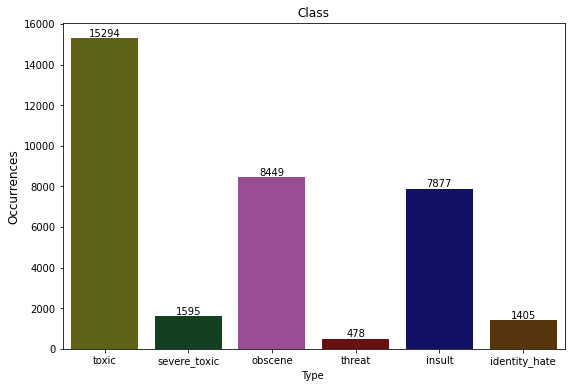

None

In [ ]:
import seaborn as sns
colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=toxicWordsTrain.iloc[:,2:].sum()
#print(x.index)
plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

display(plt.show())

In [ ]:
# Sample from dataset
for sample_i in range(3):
    print('Comment #{}:  {}'.format(sample_i + 1, x_train[sample_i]))
    print('Label #{}:    {}'.format(sample_i + 1, y_train[sample_i]))

Comment #1:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Label #1:    [0 0 0 0 0 0]
Comment #2:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Label #2:    [0 0 0 0 0 0]
Comment #3:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Label #3:    [0 0 0 0 0 0]


In [ ]:
# Explore vocabulary
import collections
from tqdm import tqdm

# Create a counter object for each dataset
word_counter = collections.Counter([word for sentence in tqdm(x_train, total=len(x_train)) \
                                                              for word in sentence.split()])

print('{} words.'.format(len([word for sentence in x_train for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('10 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')

100%|██████████| 159571/159571 [00:01<00:00, 126935.00it/s]


10734904 words.
532299 unique words.
10 Most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


The dataset contains 10,734,904 words, 532,299 of which are unique, and the 10 most common being: "the", "to", "of", "and", "a", "I", "is", "you", "that", and "in". One problem here is that we are counting uppercase words as different from lower case words and a bunch of other symbols that aren't really useful for our goal.
A data cleanup will be done in the next step.

### Preprocessing the data

We preprocess our data a bit so that it's in a format we can input into a neural network. The process includes:

1. Remove irrelevant characters (```!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n```).
2. Convert all letters to lowercase (HeLlO -> hello).
3. Tokenize our words (hi how are you -> [23, 1, 5, 13]).
4. Standaridize our input length with padding (hi how are you -> [23, 1, 5, 13, 0, 0, 0]).



In [ ]:
# Tokenize and Pad
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(x_train))
tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index

# Extract variables
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in tokenized_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in tokenized_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))
print()

# Pad sequences
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

# Sample tokenization
for sample_i, (sent, token_sent) in enumerate(zip(x_train[:2], tokenized_train[:2])):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

Vocab size: 210337
Longest comment size: 1403
Average comment size: 68.22156908210138
Stdev of comment size: 101.07344657013672
Max comment size: 371

Sequence 1
  Input:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
  Output: [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]
Sequence 2
  Input:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
  Output: [96145, 52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]


After preprocessing, our vocabulary size drops to a more manageable 210,337 with a max comment size of 371 words and an average comment size of about 68 words per sentence.

### Embedding

The data representation for our vocabulary is one-hot encoding where every word is transformed into a vector with a 1 in its corresponding location. For example, if our word vector is [hi, how, are, you] and the word we are looking at is "you", the input vector for "you" would just be [0, 0, 0, 1]. This works fine unless our vocabulary is huge - in this case, 210,000 - which means we would end up with word vectors that consist mainly of a bunch of 0s.

Instead, we can use a Word2Vec technique to find continuous embeddings for our words. Here, we'll be using the pretrained [FastText embeddings](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) from Facebook to produce a 300-dimension vector for each word in our vocabulary.

The benefit of this continuous embedding is that words with similar predictive power will appear closer together on our word vector. The downside is that this creates more of a black box where the words with the most predictive power get lost in the numbers.

In [ ]:
embedding_dim = 300

# Get embeddings
embeddings_index = {}
f = open('/content/drive/MyDrive/monolingualTCC/wiki.en.vec', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 2519371 word vectors.


In [ ]:
# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

The above is a lengthy process and hence saving the output to the disk.

In [ ]:
# Save embeddings
import h5py
with h5py.File('embeddings.h5', 'w') as hf:
    hf.create_dataset("fasttext",  data=embedding_matrix)

In [ ]:
# Load embeddings
with h5py.File('embeddings.h5', 'r') as hf:
    embedding_matrix = hf['fasttext'][:]

## Model

Long Short Term Memory with word embeddings

>The RNN type model used here is the LSTM model. This model is attractive because the individual cell states in the model have the ability to remove or add information to the cell state through gates layers. This is useful in practice because it allows the model to remember insights derived from words throughout the comment. The LSTM model consist of one densely connected layer with 60 units across the concatenated word vectors for each of the words in the comment

Now that the data is preprocessed and our embeddings are ready, we can build a model. We will build a neural network architecture that is comprises of the following:

1. Embedding layer - word vector representations.
2. Recurrent layer (LSTM) - run multiple filters over the data.
3. Fully connected layer - classify input based on filters.

In [ ]:
import keras.backend
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam

# Initate model
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))

# Add Recurrent layer
#model.add(Bidirectional(CuDNNGRU(300, return_sequences=True)))
model.add(LSTM(60, return_sequences=True, name='lstm_layer'))
#model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

# Summarize the model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 371, 300)          63101400  
_________________________________________________________________
lstm_layer (LSTM)            (None, 371, 60)           86640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 123, 60)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60)                240       
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0

### Compile the model
We'll be using binary crossentropy as our loss function and clipping our gradients to avoid any explosions.

In [ ]:
def loss(y_true, y_pred):
     return keras.backend.binary_crossentropy(y_true, y_pred)

lr = .0001
model.compile(loss=loss, optimizer=Nadam(lr=lr, clipnorm=1.0),
              metrics=['binary_accuracy'])

### Evaluation Metric

To evaluate our model, we'll be looking at its AUC ROC score (area under the receiver operating characteristic curve). We will be looking at the probability that our model ranks a randomly chosen positive instance higher than a randomly chosen negative one. 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=1, max_epoch = 100):
        super(Callback, self).__init__()
        # Initialize state variables
        print("After init")
        self.interval = interval
        self.filepath = filepath
        self.stopped_epoch = max_epoch
        self.best = 0
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        print("Epoch end 1")
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            current = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = current

            if current > self.best: #save model
                print(" - AUC - improved from {:.5f} to {:.5f}".format(self.best, current))
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch+1
                self.model.save(self.filepath, overwrite=True)
            else:
                print(" - AUC - did not improve")
            
[X, X_val, y, y_val] = train_test_split(processed_X_train, y_train, test_size=0.03, shuffle=False)
RocAuc = RocAucEvaluation(filepath='model.best.hdf5',validation_data=(X_val, y_val), interval=1)

After init


### Train the model
Using a batch size of 64 and set the number of epochs as 3

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss='binary_crossentropy', optimizer='Adam')

# Set variables
batch_size = 64
epochs = 3

# Set early stopping
early_stop = EarlyStopping(monitor="roc_auc_val", mode="max", patience=2)
                                                    
# Train
graph = model.fit(X, y, batch_size=batch_size, epochs=epochs,
                  validation_data=(X_val, y_val), callbacks=[RocAuc, early_stop],
                  verbose=1, shuffle=False)

Epoch 1/3
2419/2419 [==============================] - 1421s 584ms/step - loss: 0.1218 - val_loss: 0.0518
Epoch end 1


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


 - AUC - improved from 0.00000 to 0.98402
Epoch 2/3
2419/2419 [==============================] - 1409s 582ms/step - loss: 0.0421 - val_loss: 0.0524
Epoch end 1


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


 - AUC - improved from 0.98402 to 0.98635
Epoch 3/3
2419/2419 [==============================] - 1468s 607ms/step - loss: 0.0327 - val_loss: 0.0504
Epoch end 1


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


 - AUC - improved from 0.98635 to 0.98707


After training our model, we end up with an AUC ROC score of 98.707% higher as compared to 97.991% of the CNN with character embeddings.

In [ ]:
graph.history['val_loss']
for key in graph.history.keys():
    print(key)

loss
val_loss
roc_auc_val


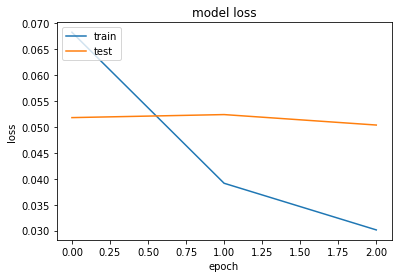

In [ ]:
# Visualize history of loss
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Load best weights and predict

In [ ]:
predictions = model.predict(processed_X_test, verbose=0)

### App prediction
An app pipeline that can be put into production for toxic comment classification. It will take in a string and return the odds that it is any one of the toxic classifications.

In [ ]:
def toxicity_level(string):
    """
    Return toxicity probability based on inputed string.
    """
    # Process string
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(new_string)
    
    # Print output
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

toxicity_level('go jump off a bridge jerk')
toxicity_level('i will kill you')
toxicity_level('have a nice day')
toxicity_level('hola, como estas')
toxicity_level('hola mierda joder')
toxicity_level('fuck off!!')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         100%
Severe Toxic:  3%
Obscene:       73%
Threat:        4%
Insult:        94%
Identity Hate: 0%

Toxicity levels for 'i will kill you':
Toxic:         98%
Severe Toxic:  2%
Obscene:       2%
Threat:        97%
Insult:        6%
Identity Hate: 1%

Toxicity levels for 'have a nice day':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'hola, como estas':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'hola mierda joder':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'fuck off!!':
Toxic:         100%
Severe Toxic:  18%
Obscene:       100%
Threat:        0%
Insult:        69%
Identity Hate: 0%



In [ ]:
toxicity_level('Hello, How are you?')

Toxicity levels for 'Hello, How are you?':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

